# ML for Images
* **Refresher** : ML Problem Formulation
* **CNN** : History & Intution
* **Learning example** : How to recognize digit?

## ML Problem Formulation

### Inner Loop

***
$\mathbf{\text{Learning objective}}$<br/>
***
Given data (x,y) find weights (w) such that f(w,x) is close to y. 
We say that we learnt model f with parameters w. 
Loss L measures gap between reality and prediction and is used by model as feedback.

\begin{align}
w^{*} = \underset{w}{\textrm{arg min}} \; L(y,\hat{y}) \\
w^{*} = \underset{w}{\textrm{arg min}} \; L(y,f(w,x))
\end{align}

***
$\mathbf{\text{Back Prop}}$<br/>
***
1.&emsp;Initialize model with random weights $$w = w_{0}$$
2. For m = 1 to epochs:<br>
(a)&emsp;Run forward pass by estimating output given current weights $$\hat{y} = f(x,w)$$ 
(b)&emsp;Calculate loss based on the difference between estimated and real outputs. b is batch size. Square loss is an example of simple loss function. $$ L = \sum \limits_{j=1}^b (y-\hat{y})^2 $$ 
(c)&emsp;Calculate loss gradient with respect to weight and use it to update the weight parameter. Alpha is step size. $$ w = w - \nabla_{w} L * \alpha $$
(d)&emsp;Stop when Loss is very small or when patience runs out



**Linux**
<br />

**Artificial Neuron**
<img src="images/BioNeuron.png" />

<br />
<br />

**Artificial Neural Network**
<img src="images/NeuralNetwork.png" />

**Optimizer steps along a loss landscape**
<img src="images/loss-optimizer.gif" />

**Loss landscape for popular architecture**

<br />

*VGG*
<img src="images/loss-vgg.png" width="500" height="600" />

<br />

*Resnet*
<img src="images/loss-resnet.png" width="500" height="600" />

## Convolution Neural Net : History & Intution

**Lenet-5 : CNN for recognizing digits**
<img src="images/lenet5.png" />

### Hubel & Weisel cat experiment

**Observations**
* the neurons fired only when the line was in a particular place on the retina.
* the activity of these neurons changed depending on the orientation of the line.
* sometimes the neurons fired only when the line was moving in a particular direction.

**Findings**
* there is a topographical map in the visual cortex that represents the visual field, where nearby cells process information from nearby visual fields.  
* neurons in the visual cortex are arranged in a precise architecture.  Cells with similar functions are organized into columns, tiny computational machines that relay information to a higher region of the brain.

**Learnings**
* Introduce filters to process local visual information.
* Build higher level abstractions in the network architecture.


**Hubel Wiesel Cat Experiment**
<img src="images/hubel-wiesel.png" />

**Visualize CNN : Zeiler and Fergus**

*Layer 1-2*
<img src="images/cnn-layer1-2.png" />

*Layer 3*
<img src="images/cnn-layer3.png" />

*Layer 4-5*
<img src="images/cnn-layer4-5.png" />

## Recognize handwritten digits using CNN

In [1]:
from matplotlib import pyplot
from pathlib import Path

import gzip
import numpy as np
import pickle
import requests

import torch
import torch.nn.functional as F

from torch import nn
from torch import optim
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset

from pytorch_model_summary import summary
from torch.utils.tensorboard import SummaryWriter

In [2]:
#Download data
DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)
URL = "https://github.com/pytorch/tutorials/raw/master/_static/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
    content = requests.get(URL + FILENAME).content
    (PATH / FILENAME).open("wb").write(content)

In [3]:
#Load data in memory
with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
    ( (x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding = "latin-1")

3
(50000, 784)
<class 'numpy.ndarray'>


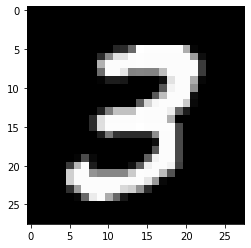

In [4]:
#Plot sample numpy array as image
sample_index = 7

pyplot.imshow(x_train[sample_index].reshape((28,28)),cmap="gray")
print(y_train[sample_index])
print(x_train.shape)
print(type(x_train))

In [5]:
#Transform numpy data into tensors 
x_train, y_train, x_valid, y_valid = map(torch.tensor, (x_train,y_train, x_valid, y_valid))
n, c = x_train.shape
print(x_train, y_train)
print(x_train.shape)
print(type(x_train))
print(y_train.min(), y_train.max())

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) tensor([5, 0, 4,  ..., 8, 4, 8])
torch.Size([50000, 784])
<class 'torch.Tensor'>
tensor(0) tensor(9)


In [6]:
#Wrap data to get access to iterator
train_ds = TensorDataset(x_train, y_train)
valid_ds = TensorDataset(x_valid, y_valid)

In [7]:
def get_data(train_ds, valid_ds, bs):
    """ Returns data loader given batch size. Training is shuffled. Validation batch size is doubled """
    train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)
    valid_dl = DataLoader(valid_ds, batch_size=2*bs)

    return (train_dl, valid_dl)

In [8]:
def loss_batch(model, loss_func, xb, yb, opt=None):
    """ 
        Data goes through forward pass and the output is compared to labels to find loss.
        Backward pass in executed if optimizer is given as in the training stage 
    """
    loss = loss_func(model(xb), yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()
    
    return loss.item(), len(xb)

In [9]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    """ 
    Data is fit to model and the model improves from the loss feedback during training stage. 
    Validation stage considers model static. 
    """
    writer = SummaryWriter()
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            loss_batch(model, loss_func, xb, yb, opt)
        
        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
            )
        val_loss = np.sum(np.multiply(losses, nums))/np.sum(nums)
        writer.add_scalar('Loss/Val', val_loss, epoch)

        print(epoch, val_loss)

In [10]:
""" 
writer = SummaryWriter()

for n_iter in range(100):
    writer.add_scalar('Loss/train', np.random.random(), n_iter)
    writer.add_scalar('Loss/test', np.random.random(), n_iter)
    writer.add_scalar('Accuracy/train', np.random.random(), n_iter)
    writer.add_scalar('Accuracy/test', np.random.random(), n_iter) 
"""

" \nwriter = SummaryWriter()\n\nfor n_iter in range(100):\n    writer.add_scalar('Loss/train', np.random.random(), n_iter)\n    writer.add_scalar('Loss/test', np.random.random(), n_iter)\n    writer.add_scalar('Accuracy/train', np.random.random(), n_iter)\n    writer.add_scalar('Accuracy/test', np.random.random(), n_iter) \n"

In [11]:
#global data
bs = 64

In [12]:
# Broker : Avoids hardcoding between data(input schema) & model
# This is achieved by keeping the input data transformation within the preprocess method. 
# WrappedDataLoader thus abstracts tranformation to 4 part tensor that is needed for the model.
def preprocess(x, y):
    return x.view(-1, 1, 28, 28), y


class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        batches = iter(self.dl)
        for b in batches:
            yield (self.func(*b))

train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
train_dl = WrappedDataLoader(train_dl, preprocess)
valid_dl = WrappedDataLoader(valid_dl, preprocess)

nn.Sequential
------------------------

``torch.nn`` has another handy class we can use to simplify our code:
`Sequential <https://pytorch.org/docs/stable/nn.html#torch.nn.Sequential>`_ .
A ``Sequential`` object runs each of the modules contained within it, in a
sequential manner. This is a simpler way of writing our neural network.

To take advantage of this, we need to be able to easily define a
**custom layer** from a given function.  For instance, PyTorch doesn't
have a `view` layer, and we need to create one for our network. ``Lambda``
will create a layer that we can then use when defining a network with
``Sequential``.



In [13]:
class Lambda(nn.Module):
    """ Custom class inheriting from nn.Module with a forward method so that it can be used as a Layer in the Sequential class"""
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)

In [14]:
#Build a CNN model
# Avoid hardcoding by having a custom last layer that returns a tensor with shape (bs=batch_size, 10=probability_digit)
# Avoid hardcoding by having last but one AdaptiveAvgPool layer that adapts input to produce output of shape 1*1. 
model = nn.Sequential(
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AdaptiveAvgPool2d(1),
    Lambda(lambda x: x.view(x.size(0), -1)),
)


In [15]:
#Visualize model layers assuming batch-size of 1

# show input shape
print(summary(model, torch.zeros((1, 1, 28, 28)), show_input=True))

# show output shape
print(summary(model, torch.zeros((1, 1, 28, 28)), show_input=False))

---------------------------------------------------------------------------
          Layer (type)         Input Shape         Param #     Tr. Param #
              Conv2d-1      [1, 1, 28, 28]             160             160
                ReLU-2     [1, 16, 14, 14]               0               0
              Conv2d-3     [1, 16, 14, 14]           2,320           2,320
                ReLU-4       [1, 16, 7, 7]               0               0
              Conv2d-5       [1, 16, 7, 7]           1,450           1,450
                ReLU-6       [1, 10, 4, 4]               0               0
   AdaptiveAvgPool2d-7       [1, 10, 4, 4]               0               0
              Lambda-8       [1, 10, 1, 1]               0               0
Total params: 3,930
Trainable params: 3,930
Non-trainable params: 0
---------------------------------------------------------------------------
---------------------------------------------------------------------------
          Layer (type)       

In [16]:
#Plot model for tensorboard graph
writer = SummaryWriter()
bs=64
images=torch.zeros((bs, 1, 28, 28))
writer.add_graph(model, images)
writer.close()

In [17]:
#Global variables for model & training
loss_func = F.cross_entropy
lr = 0.5  # learning rate
epochs =10

In [18]:
#Optimizer to find weights that minimizes loss efficiently
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

In [22]:
#TODO: Initialize so that training across runs is consistent. Also learning rate can be reduced.
# Error less than 0.2 is good
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.4438926838874817
1 0.44553573632240295
2 0.45621789371967314
3 0.42846098709106445
4 0.4634598870754242
5 0.4105317938566208
6 0.4437451243162155
7 0.4237474972963333
8 0.4372615681409836
9 0.43016823930740355


In [23]:
def accuracy(out, yb):
    """ 
        Human readable quality metric. Loss is used by machine for feedback. Accuracy is for humans.
        Returns measure of the number of times the model predicted the correct digit.
    """
    preds = torch.argmax(out, dim=1)
    return (preds == yb).float().mean()

In [24]:
#Measure model accuracy on a batch, valid has double the size than bs
train_dli, valid_dli = get_data(train_ds, valid_ds, bs=64)
valid_wdl = WrappedDataLoader(valid_dli, preprocess)
xs_b0, y_b0 = next(iter(valid_wdl))
print("Shape of tensor batch is {0}".format(xs_b0.shape))
digit_accuracy=accuracy(model(xs_b0), y_b0)
print("Percent accuracy is {0} percent on a batch size of {1} on valid dataset".format(digit_accuracy*100, 2*bs))

Shape of tensor batch is torch.Size([128, 1, 28, 28])
Percent accuracy is 96.875 percent on a batch size of 128 on valid dataset


In [27]:
#Run inference
#Take slice from input tensor; (0:1) points to zeroth sample, (1:2) points to first sample
index=45
xs_b0_infer= xs_b0[index:index+1, :, :, :]
y_b0_infer = y_b0[index]
#print(xs_b0_infer.shape)
#print(y_b0_infer)

#prediction probs
y_out= model(xs_b0_infer)
print("Model predicted probability for the image is\n{0}\n".format(y_out))

#predicted digit
y_pred = torch.argmax(y_out, dim=1)
print("Model predicts digit {0}".format(y_pred))

Model predicted probability for the image is
tensor([[0.0000, 0.0000, 0.0000, 9.4775, 0.0000, 0.0000, 2.3401, 0.0000, 0.0000,
         0.0000]], grad_fn=<ViewBackward>)

Model predicts digit tensor([3])


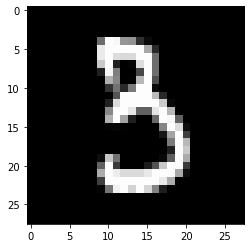

In [28]:
#Plot to visually observe the sample
pyplot.imshow(xs_b0_infer.reshape((28,28)),cmap="gray")

In [29]:
print(torch.cuda.is_available())

True


In [30]:
dev = torch.device(
    "cuda") if torch.cuda.is_available() else torch.device("cpu")
print(dev)

cuda


In [31]:
?model

Signature:      model(*input, **kwargs)
Type:           Sequential
String form:   
Sequential(
           (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
           (1): ReLU() <...> e=(2, 2), padding=(1, 1))
           (5): ReLU()
           (6): AdaptiveAvgPool2d(output_size=1)
           (7): Lambda()
           )
Length:         8
File:           ~/anaconda3/envs/pytorch/lib/python3.8/site-packages/torch/nn/modules/container.py
Docstring:     
A sequential container.
Modules will be added to it in the order they are passed in the constructor.
Alternatively, an ordered dict of modules can also be passed in.

To make it easier to understand, here is a small example::

    # Example of using Sequential
    model = nn.Sequential(
              nn.Conv2d(1,20,5),
              nn.ReLU(),
              nn.Conv2d(20,64,5),
              nn.ReLU()
            )

    # Example of using Sequential with OrderedDict
    model = nn.Sequential(OrderedDict([
              ('